# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

In [ ]:
# Run this cell to mount Google Drive for Colab
from google.colab import drive
drive.mount('/content/drive/')
# !ls "/content/drive/My Drive/"http://localhost:8888/notebooks/Quadcopter_Project.ipynb#

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/RL-Quadcopter-2')

In [ ]:
import matplotlib.pyplot as plt
import visuals

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [0]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [0]:
import csv
import numpy as np
from tasks.task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'BasicAgent_History.csv'           # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the **position** and **velocity** of the quadcopter evolved during the simulation.

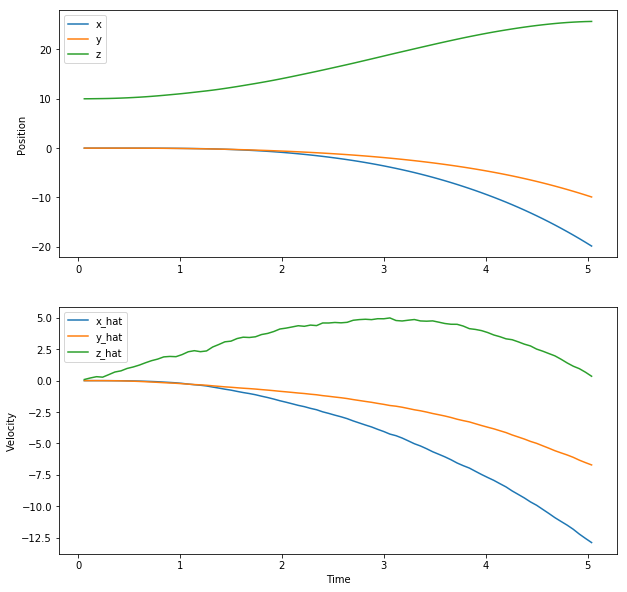

In [0]:
visuals.plot_position(file_output, size=(10, 10))

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes) and the velocities (in radians per second) corresponding to each of the Euler angles.

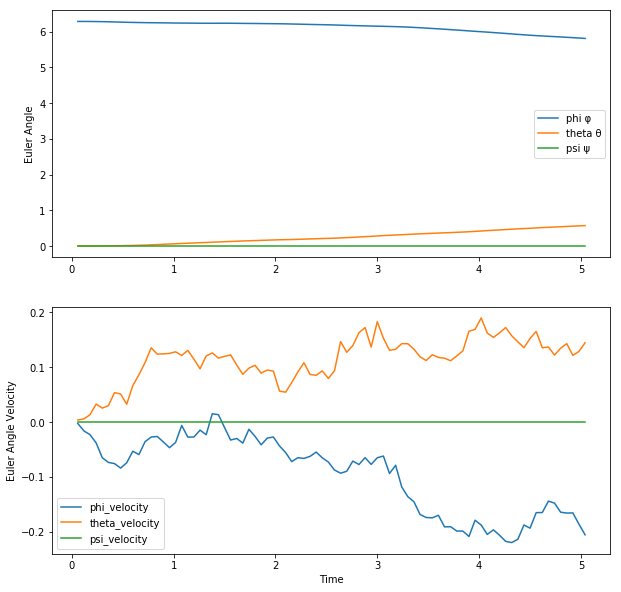

In [0]:
visuals.plot_euler_angle(file_output, size=(10, 10))

Finally, you can use the code cell below to print the agent's choice of actions.  

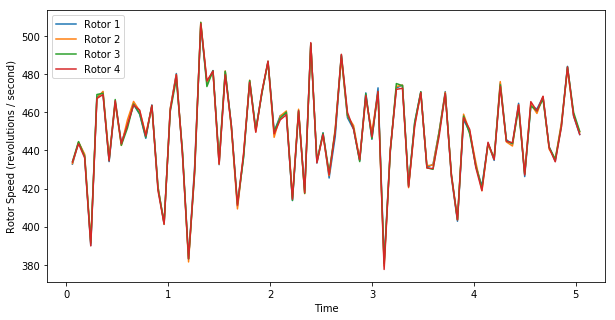

In [0]:
visuals.plot_rotor_speed(file_output, size=(10, 5))

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [0]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-6.9994045   2.66047426 28.34535746  0.03419123  0.40229795  0.        ]
[-5.52156787  2.0542151   4.98641309]
[-0.05555936  0.20116559  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, **you are welcome to expand the size of the state vector by including the velocity information**.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered **done** if the **time limit** has been exceeded, or the quadcopter has travelled **outside of the bounds** of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [0]:
import sys
import numpy as np
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from tasks.task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task)

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state)
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -3.028 (best =   0.469), noise_scale = 3.25

In [0]:
import csv

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4',
          'reward']

file_history = 'PolicySearch_Agent_History.csv'

# Run the simulation, and save the results.
state = agent.reset_episode()
with open(file_history, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    writer.writerow([task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward])
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        writer.writerow([task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward])
        state = next_state
        if done:
            print("score = {:7.3f}, noise_scale = {}".format(agent.score, agent.noise_scale))
            break

score =  -3.028, noise_scale = 3.2


### 3D Trajectory for Policy Search Agent

* <font color='blue'>Blue mark</font> represnets the start point
* <font color='red'>Red mark</font> represnets the end point

<a href="imgs/PolicySearch_Agent_History.png" target="_blank"><img src="imgs/PolicySearch_Agent_History.png" alt="PolicySearch 3D Trajectory" title="PolicySearch 3D Trajectory"></a>

In [8]:
visuals.plot_trajectory_3d('PolicySearch_Agent_History.csv', 'PolicySearch Trajectory', filename='PolicySearch Trajectory',
                           width=700, height=700, axis_ranges=([-5,5], [-5,5], [0,11]))

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

## Vertical Takeoff Task

In [0]:
## TODO: Train your agent here.
import sys
import numpy as np
import pandas as pd
from agents.ddpg import DDPG
from tasks.vtakeoff_task import VerticalTakeoffTask

runtime = 5.                                     # time limit of the episode
init_pos = np.array([2., 3., 0., 0., 0., 0.])    # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

task = VerticalTakeoffTask(init_pos, init_velocities, init_angle_velocities, runtime)
agent = DDPG(task, batch_size=64)
best_total_reward = -np.inf
rewards_list = []

In [6]:
num_episodes = 1000
episode_num_start = 1

for i_episode in range(episode_num_start, episode_num_start+num_episodes):
    total_reward = 0
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state)
        # Take action, get new state and reward
        next_state, reward, done = task.step(action)
        total_reward += reward
        agent.step(action, reward, next_state, done)
        state = next_state
        if done:
            rewards_list.append((i_episode, total_reward))
            
            if total_reward > best_total_reward:
                best_total_reward = total_reward
            
            print("\rEpisode={:4d}, TotalReward={:7.3f} (Best={:7.3f}), x={:5.3f}, y={:5.3f}, z={:5.3f}, time={:4.2f}".format(
                i_episode, total_reward, best_total_reward, task.sim.pose[0], task.sim.pose[1], task.sim.pose[2], task.sim.time), end='')
            sys.stdout.flush()
            break

Episode=1000, TotalReward=250.333 (Best=250.333), x=-0.889, y=-1.522, z=127.465, time=5.02

In [0]:
# Save reward per episode to file
import csv

with open('VTakeoff_Training_Rewards.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Episode', 'Total Reward'])
    writer.writerows(rewards_list)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

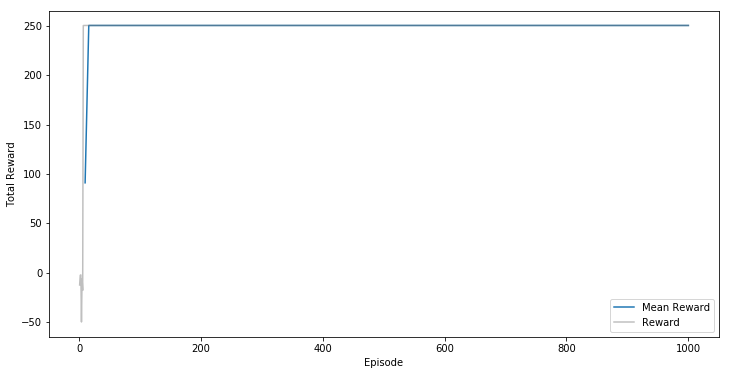

In [8]:
visuals.plot_rewards(rewards_list, 10)

## Run Vertical Takeoff Simulations from Different Initial Positions

In [9]:
import csv

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4',
          'reward']

init_pos_list = [np.array([5., 1., 0., 0., 0., 0.]),
                 np.array([10., 10., 0., 0., 0., 0.]),
                 np.array([11., 7., 0., 0., 0., 0.])]

for i in range(len(init_pos_list)):
    task.sim.init_pose = init_pos_list[i]
    file_history = "DDPG_VTakeoff_History_{}.csv".format(i)

    # Run the simulation, and save the results.
    state = agent.reset_episode()
    with open(file_history, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)
        writer.writerow([task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward])
        total_reward = 0
        while True:
            action = agent.act(state, False)
            next_state, reward, done = task.step(action)
            total_reward += reward
            writer.writerow([task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward])
            state = next_state
            if done:
                print("Total Reward={:7.3f}, x={:5.3f}, y={:5.3f}, z={:5.3f}".format(
                    total_reward, task.sim.pose[0], task.sim.pose[1], task.sim.pose[2]))
                break

Total Reward=250.333, x=5.000, y=1.000, z=127.463
Total Reward=250.333, x=10.000, y=10.000, z=127.463
Total Reward=250.333, x=11.000, y=7.000, z=127.463


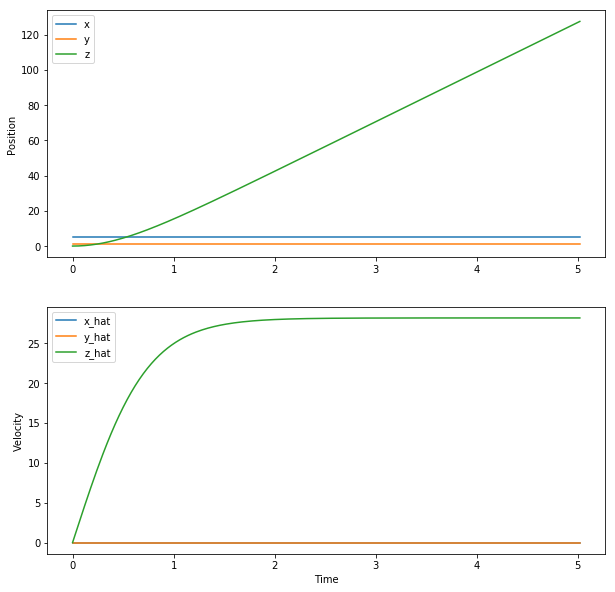

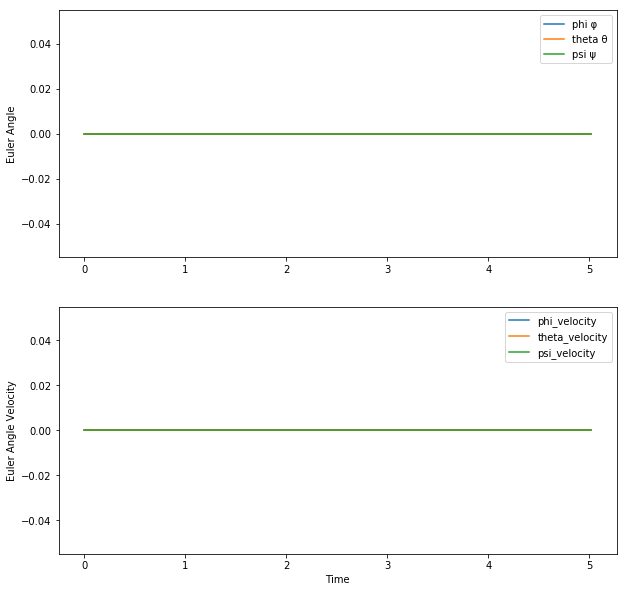

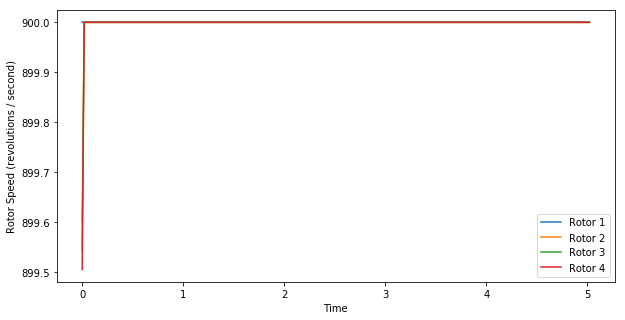

In [10]:
# Visualization for an initial position.
file_ddpg_vtakeoff = 'DDPG_VTakeoff_History_0.csv'
visuals.plot_position(file_ddpg_vtakeoff, size=(10, 10))
visuals.plot_euler_angle(file_ddpg_vtakeoff, size=(10, 10))
visuals.plot_rotor_speed(file_ddpg_vtakeoff, size=(10, 5))

### 3D Trajectory for DDPG Agent

* <font color='blue'>Blue mark</font> represnets the start point
* <font color='red'>Red mark</font> represnets the end point

<a href="imgs/DDPG_VTakeoff_History_0.png" target="_blank"><img src="imgs/DDPG_VTakeoff_History_0.png" alt="DDPG 3D Trajectory" title="DDPG 3D Trajectory"></a>

In [5]:
visuals.plot_trajectory_3d('DDPG_VTakeoff_History_0.csv', 'DDPG Trajectory', filename='DDPG Trajectory',
                           width=800, height=800, axis_ranges=([-10,10], [-10,10], [0,120]))

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

The takeoff task is defined in `vtakeoff_task.py`.

***Goal***

The quadcopter can take off vertically as high as possible within a limited period of time (5s) from any initial position.

***State / Observation***

At first the state was represented by `task.sim.pose[:3]` (position), `task.sim.pose[3:]` (Euler angles), `task.sim.v` (velocities) and `task.sim.angular_v` (angular velocities). However, I found that the agent could not take off vertically after successful training if the initial position was different from the one used for training. I thought this problem was mainly caused by the position of the state, so I removed `task.sim.pose[:3]` (position) from the state then tried to train the agent again.

***Action***

The minimum (`action_low`) was changed from 0 to 1 to avoid the "divide by zero" error in the simulator.

***Reward Function***

The reward is defined as the **hyperbolic tangent of $R$**. The purpose of hyperbolic tangent is to scale rewards between -1 and 1 to avoid instability in training due to exploding gradients. $R$ is defnied as below:

\begin{equation*}
R=\begin{cases}
-20 & \text{No Takeoff}\\
-5 & \text{Crash}\\
0.8v_{z} -0.2( |v_{x} |+|v_{y} |) -0.01( |a_{φ} |+|a_{θ} |+|a_{ψ} |) & \text{Otherwise}
\end{cases}
\end{equation*}

where $v$ denotes velocities and  $a$ denotes angular velocities. $v$<sub>*z*</sub> has the highest coefficient since vertical takeoff is what we care about the most. The reward function was inspired by the Humanoid Reward defined in this paper<sup>1</sup>.

- **0.8$v$<sub>*z*</sub>:** Return positive reward if the quadcopter flies straight up, otherwise it will return negative value for penalization.
- **0.2(|$v$<sub>x</sub>| + |$v$<sub>y</sub>|):** Penalize any x- and y-direction velocities since the goal is to take off vertically.
- **0.01(|$a$<sub>φ</sub>| + |$a$<sub>θ</sub>| + |$a$<sub>ψ</sub>|):** Penalize wasting energy on φ, θ and ψ angular velocities.

***References***
1. [Emergence of Locomotion Behaviours in Rich Environments](https://arxiv.org/abs/1707.02286)

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

***Learning Algorithm***

I only tried the Deep Deterministic Policy Gradient (DDPG)<sup>1</sup> algorithm as it was already able to finish the task. The DDPG agent consists of `ddpg.py`, `replay_buffer.py` and `ou_noise.py`, and original implementation of these components are provied by the Udacity course.

***Final Hyperparameters***

Most hyperparameters refer to the original DDPG paper<sup>1</sup>.

- **Discount factor of $\gamma$:** 0.99
- **Minibatch size:** 64
- **Replay buffer size:** 100000
- **Soft target update $\tau$:** 0.1
- Ornstein–Uhlenbeck process
 - **$\mu$:** 0
 - **$\theta$:** 0.15
 - **$\sigma$:** 0.2

***Neural Network Architecture***

The network architectures mostly follow the original DDPG paper<sup>1</sup> as shown in the below two images which were generated by [Netron](https://github.com/lutzroeder/netron). I also used Adam optimizer with a learning rate of 0.0001 and 0.001 for actor and critic respectively. In critic, an extra dense layer of 64 units was added prior to the final output layer, and all hidden layers incorporated L2-regularizer with weight decay of 0.01 for `kernel_regularizer`.

****Actor****

<a href="imgs/ddpg-actor.png" target="_blank"><img src="imgs/ddpg-actor.png" alt="Actor Architecture" title="Actor Architecture" style="max-height:600px;"></a>

****Critic****

<a href="imgs/ddpg-critic.png" target="_blank"><img src="imgs/ddpg-critic.png" alt="Critic Architecture" title="Critic Architecture" style="max-height:600px;"></a>

**References**:

1. [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

- According to the [episode rewards plot](#Plot-the-Rewards), it seems an easy task to learn as the reward reaches a plateau in just a few episodes. However, this was not always the case. Sometimes the agent did not converge on a high reward. Based on a few repeated experiments, the agent could learn the task successfully once in two or three tries.
- There was an aha moment because the reward suddenly changed from a small negative value to a high positive value and remained on a high level.
- The performance of the agent was excellent. The rewards remain high and stable starting from the early episodes. I have performed three vertical takeoff simulations from different initial positions, and the quadcopter was able to fly straight up in all simulations. [Here](#3D-Trajectory-for-DDPG-Agent) shows the 3D trajectory generated by [plotly](https://plot.ly/) in a simulation.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

I think this is the most challenging project so far in the ML Engineer Nanodegree Program. I started with reading the origianl DDPG paper to understand more details about the algorithm. To get more sense about how the quadcopter actually flies, I tried to find a 3D simulator which can display the animation of the quadcopter. Unfortunately I didn't find one that is easy to use, so finally decided to utilize [plotly](https://plot.ly/) for plotting the 3D trajectory.

Actually I tried to solve the "reach target positon" task in the beginning, but after several days of trial and error without seeing a promising solution, I decided to go for the easier task "vertical takeoff". Even this task is not easy for the DDPG agent to learn. I think the hardest part of the project is that there are infinite possible combinations of hyperparameters, network architectures and reward functions. Each combination requires a bunch of time to train. Furthermore, you are not sure if DDPG is powerful enough to learn the task or you should resort to other algorithm after a lot of frustrating results. All I can do is refer to the settings of previous literatures, gradually change the settings, and keep reviewing whether my reward function is reasonable.

Most people would intuitively know that the best solution of the vertical takeoff task is to set the 4 rotors at max speed all the time, but it's not that easy for the agent to learn. The final agent demonstrated above learned the optimal solution, but in fact I have trained an agent which only set 2 rotors at max speed. The quadcopter can still fly straight up under this condition but slower.

Besides keep polishing the reward function, there are two ideas might worth trying to improve the agent.
- Use prioritized experience replay instead of only random sampling from memory
- Exploration with parameter noise<sup>1</sup> instead of action space noise

**References**:

1. [Parameter Space Noise for Exploration](https://arxiv.org/abs/1706.01905)